In [ ]:
# Interpolating WACCM data onto magnetic latitude 
# Loading COSMIC data and plotting latitude line-plot of occurence freq

In [25]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import datetime as dt
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
#jet = mcm.get_cmap('jet')
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import sys
import os
import psutil
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
from tqdm import tqdm
import dask.array as da
import dask.dataframe as dd
import dask
import scipy
%matplotlib inline 
#import line_profiler
#%load_ext line_profiler

/tmp/ipykernel_4122934/2491741907.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


# WACCM Occ Freqs (Lat/Lon) - Data Loading

In [26]:

win_Monthfolderstr = 'Dec-Feb'
win_ds_months = ['12','01','02']

spr_Monthfolderstr = 'Mar-May'
spr_ds_months = ['03','04','05']

sum_Monthfolderstr = 'Jun-Aug'
sum_ds_months = ['06','07','08']

aut_Monthfolderstr = 'Sep-Nov'
aut_ds_months = ['09','10','11']


#run_name = 'Jianfei_run'
run_name = 'Wuhu_IonTr_run'
#run_name = 'Wuhu_IonTr_run_No_glbavg'

win_file = f'Nc_Files/SpE_Output/{run_name}_SpE_Output_{win_Monthfolderstr}.nc'
spr_file = f'Nc_Files/SpE_Output/{run_name}_SpE_Output_{spr_Monthfolderstr}.nc'
sum_file = f'Nc_Files/SpE_Output/{run_name}_SpE_Output_{sum_Monthfolderstr}.nc'
aut_file = f'Nc_Files/SpE_Output/{run_name}_SpE_Output_{aut_Monthfolderstr}.nc'

ds_months_ar = np.arange(0,3)   

ds_win = xr.open_dataset(win_file)
ds_spr = xr.open_dataset(spr_file)
ds_sum = xr.open_dataset(sum_file)
ds_aut = xr.open_dataset(aut_file)

ds_sum

<xarray.Dataset>
Dimensions:                    (lev: 126, lev_sl: 19, time: 336, lat: 96,
                                latsl: 36, lon: 144, LT: 48, LT_L: 144,
                                timesl: 2, mth: 3)
Coordinates:
  * lev                        (lev) float64 4.055e-10 5.207e-10 ... 970.6 992.6
  * lev_sl                     (lev_sl) float64 1.473e-05 1.891e-05 ... 0.001329
  * time                       (time) float64 0.0 1.0 2.0 ... 333.0 334.0 335.0
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * latsl                      (latsl) float64 -87.5 -82.5 -77.5 ... 82.5 87.5
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * LT                         (LT) float64 0.0 0.5 1.0 1.5 ... 22.5 23.0 23.5
  * LT_L                       (LT_L) float64 0.0 0.1667 0.3333 ... 23.67 23.83
  * timesl                     (timesl) float64 0.0 1.0
  * mth                        (mth) float64 6.0 7.0 8.0
Data variables: (12/26)
    Zavg_sl                    (lev_sl) float64 ...
    altavg                     (lev) float64 ...
    altavg_sl                  (lev_sl) float64 ...
    times_str_min              (mth, timesl) object ...
    times_str_max              (mth, timesl) object ...
    SpEs_Occ_Fr_b_dsavglevLT   (lat) float64 ...
    ...                         ...
    SpEsns                     (lev_sl, time, lat, lon, timesl, mth) float64 ...
    Mptdensns                  (lev_sl, time, lat, lon, timesl, mth) float64 ...
    Mptdens_avv1_b_5d          (lev_sl, latsl, timesl, mth) float64 ...
    Mptdens_std                (lev_sl, lat, LT_L, timesl, mth) float64 ...
    SpEs_freq_time             (lev_sl, lat, LT_L, timesl, mth) float64 ...
    SpEsns_freq_time           (lev_sl, lat, lon, timesl, mth) float64 ...

# WACCM Raw Files (ALATM/ALONM)- Data Loading

In [27]:
file1name='Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-03-*.nc'
ds = xr.open_mfdataset(file1name)
#ds

# WACCM - MagLat Interpolation

In [28]:

ALATM = ds['ALATM']     #time,lat,lon
avALATM = np.mean(ALATM, axis=0)   # Average over time dimension -> [lat,lon]

lat_min = -75  # Replace with your minimum latitude
lat_max = 75   # Replace with your maximum latitude

latsl = ds_spr['lat'].sel(lat=slice(lat_min, lat_max))
nlat = len(latsl)
nlats = np.arange(0,nlat)

nlons = np.arange(0,144)
n = np.zeros((nlat, 144 ))

# Define seasons and corresponding datasets
seasons = ['spr', 'sum', 'aut', 'win']
datasets = [ds_spr, ds_sum, ds_aut, ds_win]

# Initialize arrays for each season
n_values = {season: np.zeros((nlat, nlons.size)) for season in seasons}
SpEsns_Occ_Fr_maglat = {season: np.zeros(nlat) for season in seasons}

# Loop through seasons
for season, dataset in zip(seasons, datasets):
    # Select the relevant dataset for the current season
    ds_season = dataset['SpEsns_Occ_Fr_dsavglev'].sel(lat=slice(lat_min, lat_max))
    
    # Loop through latitudes with a progress bar
    for ilat in tqdm(nlats, desc=f'Processing {season} data', unit='latitude'):
        for ilon in nlons:
            fp = ds_season[:, ilon].values
            xp = avALATM.sel(lat=slice(lat_min, lat_max))[:, ilon].values
            x = latsl[ilat]
            n_values[season][ilat, ilon] = np.interp(x, xp, fp)

    # Calculate mean along the longitude axis
    SpEsns_Occ_Fr_maglat[season] = np.mean(n_values[season], axis=1)


Processing spr data:   2%|██▊                                                                                                             | 2/80 [00:14<09:16,  7.13s/latitude]


KeyboardInterrupt: 

In [7]:
########### Save to nc file ##########

dataset.set_index

# Create an empty xarray Dataset to store variables
result_dataset = xr.Dataset()

# Loop through seasons
for season, values in SpEsns_Occ_Fr_maglat.items():
    
    result_dataarray_occ_freq = xr.DataArray(SpEsns_Occ_Fr_maglat[season], coords={'mlat': latsl.values}, 
                                             dims=['mlat'], 
                                             name=f'{season}_Occ_Fr_maglat', 
                                             attrs={'Data': 'Occ Freq interp onto mag lat, avgd over lon dim (~avgd at each constant mag lat)', 'Dims': 'mlat'})
    
    # Add the DataArray to the Dataset
    result_dataset[f'{season}_Occ_Fr_maglat'] = result_dataarray_occ_freq

    # Access the corresponding n_values for the current season
    result_dataarray_n_values = xr.DataArray(n_values[season], coords={'mlat': latsl.values, 'lon': ds['lon'].values}, 
                                             dims=['mlat', 'lon'], 
                                             name=f'{season}_Occ_Fr_maglatlon', 
                                             attrs={'Data': 'Occ Freq interp onto mag lat', 'Dims': 'mlat & lon'})
    
    # Add the DataArray to the Dataset
    result_dataset[f'{season}_Occ_Fr_maglatlon'] = result_dataarray_n_values
    
    
    #result_dataset = result_dataset.assign_coords(mlat=result_dataset['lat'])
    #result_dataset = result_dataset.rename_dims({'lat': 'mlat'})
    #result_dataset = result_dataset.set_index(mlat='latsl')

output_directory = "./Nc_Files/SpE_Output/Mag_Coords/"
output_file = "Occ_Fr_maglat_maglatlon.nc"
result_dataset.to_netcdf(f'{output_directory}{output_file}')

# OLD CODE

In [ ]:
#========================================
# MagLat Figure Plotting
#========================================

In [19]:
#      Load WACCM Data #
#===============================

ds_Occ_Fr_maglat_maglatlon = xr.open_dataset('./Nc_Files/SpE_Output/Mag_Coords/Occ_Fr_maglat_maglatlon.nc')
mlat_w = ds_Occ_Fr_maglat_maglatlon['mlat']

spr_Occ_Fr_maglat_w = ds_Occ_Fr_maglat_maglatlon['spr_Occ_Fr_maglat']
sum_Occ_Fr_maglat_w = ds_Occ_Fr_maglat_maglatlon['sum_Occ_Fr_maglat']
aut_Occ_Fr_maglat_w = ds_Occ_Fr_maglat_maglatlon['aut_Occ_Fr_maglat']
win_Occ_Fr_maglat_w = ds_Occ_Fr_maglat_maglatlon['win_Occ_Fr_maglat']

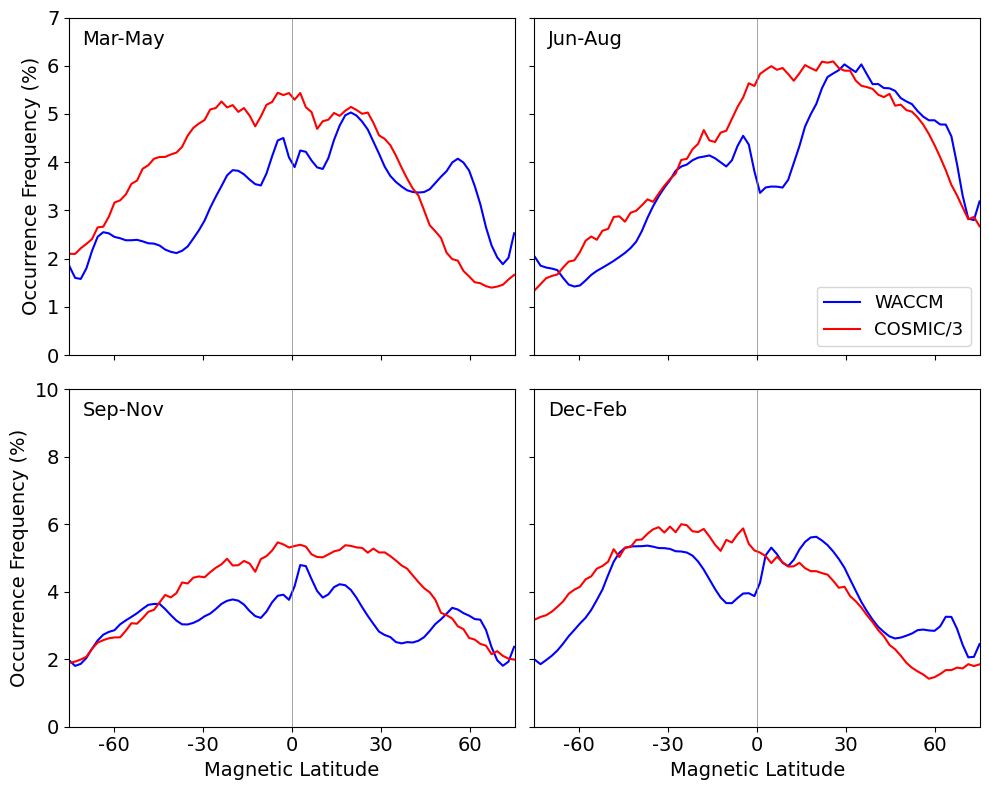

In [24]:
########### Plot L A T figure ##########

lat_values = np.arange(-90, 95, 5)
lat_bin_edges = lat_values
lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2

factor = 3

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True)

# Plot WACCM data
axes[0, 0].plot(mlat, spr_Occ_Fr_maglat_w, color='blue', label='WACCM')
axes[0, 1].plot(mlat, sum_Occ_Fr_maglat_w, color='blue', label='WACCM')
axes[1, 0].plot(mlat, aut_Occ_Fr_maglat_w, color='blue', label='WACCM')
axes[1, 1].plot(mlat, win_Occ_Fr_maglat_w, color='blue', label='WACCM')

# Plot COSMIC data magnetic lat lon
axes[0, 0].plot(mlat_c, spr_Occ_Fr_maglat_c /factor, color='red', label=f'COSMIC/{factor}')
axes[0, 1].plot(mlat_c, sum_Occ_Fr_maglat_c /factor, color='red', label=f'COSMIC/{factor}')
axes[1, 0].plot(mlat_c, aut_Occ_Fr_maglat_c /factor, color='red', label=f'COSMIC/{factor}')
axes[1, 1].plot(mlat_c, win_Occ_Fr_maglat_c /factor, color='red', label=f'COSMIC/{factor}')


# # # Fill between upper and lower bounds of the error
# axes[0, 0].fill_between(lat_bin_midpoints, (spr_ocfr_LT_m_lat.values - stdev_ocfr_mlat_LT_spr_lat.values) / factor, (spr_ocfr_LT_m_lat.values + stdev_ocfr_mlat_LT_spr_lat.values) / factor, color='red', alpha=0.3)
# axes[0, 1].fill_between(lat_bin_midpoints, (sum_ocfr_LT_m_lat.values - stdev_ocfr_mlat_LT_sum_lat.values) / factor, (sum_ocfr_LT_m_lat.values + stdev_ocfr_mlat_LT_sum_lat.values) / factor, color='red', alpha=0.3)
# axes[1, 0].fill_between(lat_bin_midpoints, (aut_ocfr_LT_m_lat.values - stdev_ocfr_mlat_LT_aut_lat.values) / factor, (aut_ocfr_LT_m_lat.values + stdev_ocfr_mlat_LT_aut_lat.values) / factor, color='red', alpha=0.3)
# axes[1, 1].fill_between(lat_bin_midpoints, (win_ocfr_LT_m_lat.values - stdev_ocfr_mlat_LT_win_lat.values) / factor, (win_ocfr_LT_m_lat.values + stdev_ocfr_mlat_LT_win_lat.values) / factor, color='red', alpha=0.3)


# Set common labels and legend
for ax in axes.flatten():
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax.set_xlim(-75, 75)
    ax.set_xticks(np.arange(-60, 61, 30))  
    ax.set_xticklabels(np.arange(-60, 61, 30)) 
    #ax.legend()
    ax.set_ylim(0, 7)

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        label = ['Mar-May', 'Jun-Aug', 'Sep-Nov','Dec-Feb'][i * 2 + j]
        ax.text(0.03, 0.92, label, transform=ax.transAxes, fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
        if i == 1:
            ax.set_xlabel('Magnetic Latitude', fontsize=14)
            ax.set_yticks(np.arange(0, 11, 2))
        if j == 0:
            ax.set_ylabel('Occurrence Frequency (%)', fontsize=14)
        else:
            ax.set_yticklabels([])  # Set yticklabels to an empty list for other columns

        

# Move the legend to the top right
#axes[0, 0].legend(loc='upper right', fontsize=13)
axes[0, 1].legend(loc='lower right', fontsize=13)
# axes[1, 0].legend(loc='lower left', fontsize=13)
# axes[1, 1].legend(loc='lower left', fontsize=13)
        
# Adjust layout
plt.tight_layout()

# Save and show the figure
#figname = f'{run_name}_Combined_Mag-Lat_s4max_{s4max_threshold}_e-crit.png'
#plt.savefig('./Figures/Combined/' + str(figname), dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
#========================================
# WACCM - MagLon Interpolation (not working!)
#========================================

In [68]:
########### L O N interpolation ##########

ALONM = ds['ALONM']     #time,lat,lon
avALONM = np.mean(ALONM, axis=0)
avALONMsel = avALONM.sel(lat=slice(lat_min, lat_max))
avALONMsh = avALONMsel.roll(lon=144// 2, roll_coords=True)

lonsh = (lon + 180) % 360 - 180    #0-360 to -180 - 180
lonshh = lonsh.roll(lon=144// 2)



lat_min = -75  # Replace with your minimum latitude
lat_max = 75   # Replace with your maximum latitude


mlatsl = ds_Occ_Fr_maglat_maglatlon['mlat']
nmlat = len(mlatsl)
nmlats = np.arange(0,nlat)

nlons = np.arange(0,144)
n = np.zeros((nmlat, 144 ))



#Define seasons and corresponding datasets
seasons = ['spr_Occ_Fr_maglatlon', 'sum_Occ_Fr_maglatlon', 'aut_Occ_Fr_maglatlon', 'win_Occ_Fr_maglatlon']


# Initialize arrays for each season
m_values = {season: np.zeros((nlat, nlons.size)) for season in seasons}


# Loop through seasons
for season in seasons:
    # Select the relevant dataset for the current season
    ds_season = ds_Occ_Fr_maglat_maglatlon[season]
    ds_seasonsh = ds_season.roll(lon=144// 2, roll_coords=True)
    
 
    for ilon in tqdm(nlons, desc=f'Processing {season} data'):
        for ilat in nmlats:
            fp = ds_season[ilat, :].values
            xp = avALONMsel[ilat,:].values
            x = lonsh[ilon]
            m_values[season][ilat, ilon] = np.interp(x, xp, fp)


Processing win_Occ_Fr_maglatlon data: 100%|██████████████████████████████████████████| 144/144 [07:30<00:00,  3.13s/it]


In [70]:
########### Save to nc file ##########

seasons = ['spr_Occ_Fr_maglatlon', 'sum_Occ_Fr_maglatlon', 'aut_Occ_Fr_maglatlon', 'win_Occ_Fr_maglatlon']

dataset.set_index

# Create an empty xarray Dataset to store variables
result_dataset = xr.Dataset()

# Loop through seasons
for season, values in m_values.items():
    # Extract the prefix (e.g., 'spr', 'sum', 'aut', 'win') from the full season name
    season_prefix = season.split('_')[0]
    
    # Access the corresponding n_values for the current season
    result_dataarray_m_values = xr.DataArray(m_values[season], coords={'mlat': latsl.values, 'mlon': lonsh.values}, 
                                             dims=['mlat', 'mlon'], 
                                             name=f'{season_prefix}_Occ_Fr_maglatmaglon', 
                                             attrs={'Data': 'Occ Freq interp onto mag lat', 'Dims': 'mlat & lon'})
    
    # Add the DataArray to the Dataset
    result_dataset[f'{season_prefix}_Occ_Fr_maglatamglon'] = result_dataarray_m_values
    
output_directory = "./Nc_Files/SpE_Output/Mag_Coords/"
output_file = "Occ_Fr_maglatmaglon.nc"
result_dataset.to_netcdf(f'{output_directory}{output_file}')

In [ ]:
#========================================
# MagLat-MagLon Figure Plotting
#========================================

In [71]:
ds_Occ_Fr_maglatmaglon = xr.open_dataset('./Nc_Files/SpE_Output/Mag_Coords/Occ_Fr_maglatmaglon.nc')
ds_Occ_Fr_maglatmaglon

<xarray.Dataset>
Dimensions:                  (mlat: 80, mlon: 144)
Coordinates:
  * mlat                     (mlat) float64 -74.84 -72.95 -71.05 ... 72.95 74.84
  * mlon                     (mlon) float64 0.0 2.5 5.0 7.5 ... -7.5 -5.0 -2.5
Data variables:
    spr_Occ_Fr_maglatamglon  (mlat, mlon) float64 ...
    sum_Occ_Fr_maglatamglon  (mlat, mlon) float64 ...
    aut_Occ_Fr_maglatamglon  (mlat, mlon) float64 ...
    win_Occ_Fr_maglatamglon  (mlat, mlon) float64 ...

In [73]:
spr_Occ_Fr_maglatmaglon = ds_Occ_Fr_maglatmaglon['spr_Occ_Fr_maglatamglon']
sum_Occ_Fr_maglatmaglon = ds_Occ_Fr_maglatmaglon['sum_Occ_Fr_maglatamglon']
aut_Occ_Fr_maglatmaglon = ds_Occ_Fr_maglatmaglon['aut_Occ_Fr_maglatamglon']
win_Occ_Fr_maglatmaglon = ds_Occ_Fr_maglatmaglon['win_Occ_Fr_maglatamglon']

mlat = ds_Occ_Fr_maglatmaglon['mlat']
mlon = ds_Occ_Fr_maglatmaglon['mlon']

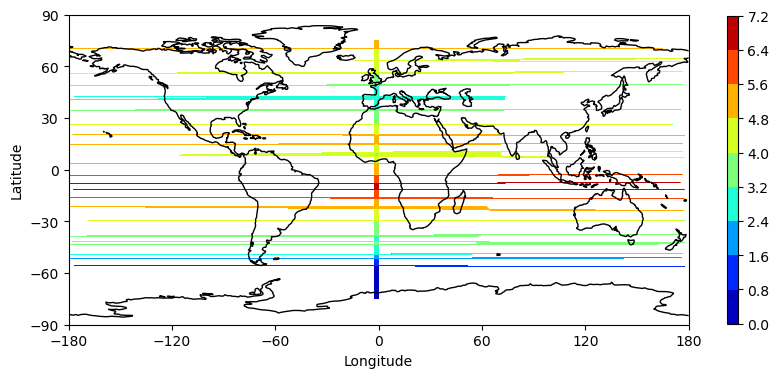

In [74]:
####### Plot Occ_Fr_maglatmaglon ########


# # Create a 2D grid using meshgrid
# lon_2d, lat_2d = np.meshgrid(lon, lat)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(mlon, mlat, spr_Occ_Fr_maglatmaglon, cmap='jet'#, levels=np.linspace(0, 0.5, 11)
                      , transform=ccrs.PlateCarree())
cbar = plt.colorbar(contour
                    #, label=''
                    , ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.5)
ax.coastlines()

ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_yticks(np.linspace(-90, 90, 7))
ax.set_ylabel('Latitude')
#ax.set_title(f'')

#gl = ax.gridlines(draw_labels=True, linestyle='--')

figname = f'.png'
#plt.savefig('./Figures/Factor/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

Additional criteria for lower limit to e_density (from lowest value of histogram created using WACCM algorithm)Additional criteria for lower limit to e_density (from lowest value of histogram created using WACCM algorithm)# Old Code 

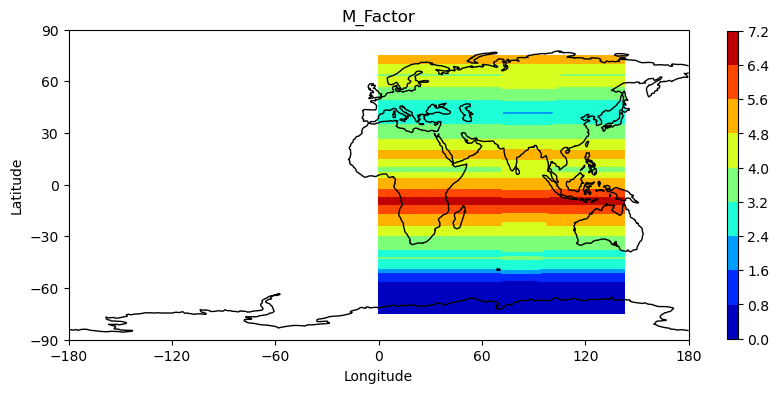

In [145]:



fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(mlon, mlat, spr_Occ_Fr_maglatmaglon, cmap='jet'#, levels=np.linspace(0, 0.5, 11)
                      , transform=ccrs.PlateCarree())
cbar = plt.colorbar(contour
                    #, label=''
                    , ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.5)
ax.coastlines()

ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_yticks(np.linspace(-90, 90, 7))
ax.set_ylabel('Latitude')
ax.set_title(f'M_Factor')

#gl = ax.gridlines(draw_labels=True, linestyle='--')

figname = f'SpEsns_Occ_Fr_maglatlon.png'
#plt.savefig('./Figures/Factor/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

In [ ]:
#//////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////

In [16]:
# Convert the Variable to DataArray
data_array = xr.DataArray(spr_SpEsns_Occ_Fr_dsavglev, coords= {'lat': lat, 'lon': lon} )

# Interpolate 'SpEs_Occ_Fr_b_dsavglev' to magnetic latitude and longitude
interpolated_data = data_array.interp(lat=avALATM, lon=avALONMshh)

In [38]:
ds_mlat = ds['mlat']
ds_mlon = ds['mlon'] #-180 - 180

ds_mlonsh = ds_mlon.roll(mlon=144// 2)#, roll_coords=True)
ds_mlonshh = (ds_mlonsh + 180) % 360     #-180 - 180 to 0-360

In [39]:
# Convert the Variable to DataArray
data_array = xr.DataArray(spr_SpEsns_Occ_Fr_dsavglev, coords= {'lat': lat, 'lon': lon} )

# Interpolate 'SpEs_Occ_Fr_b_dsavglev' to magnetic latitude and longitude
interpolated_data_2 = data_array.interp(lat=ds_mlat, lon=ds_mlonshh)

In [40]:
mlat = interpolated_data_2['lat']
mlon = interpolated_data_2['lon']

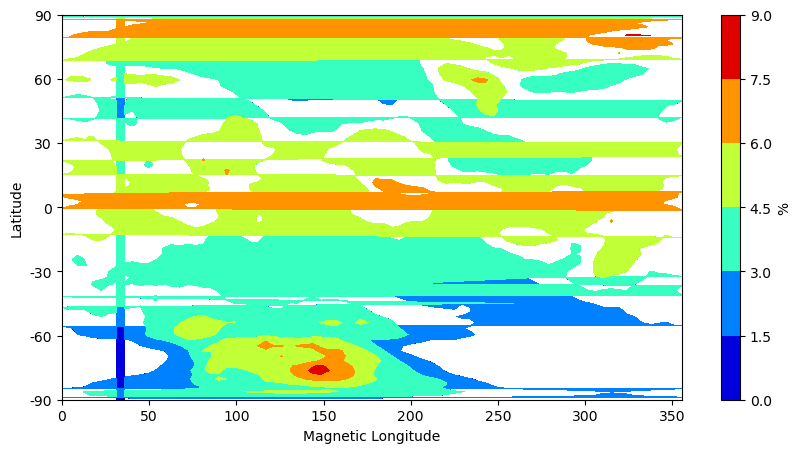

In [41]:

fig, ax = plt.subplots(figsize=(10,5))

cmap = plt.get_cmap('jet')

C = ax.contourf(#mlonsh_plot, mlat, interpolated_data_plot
                mlon, mlat, interpolated_data_2
                , cmap=cmap
                #,levels=np.linspace(vminw, vmaxw, 11), vmin=vminw, vmax=vmaxw
               )

ax.set_xlabel('Magnetic Longitude')
ax.set_ylabel('Latitude')
#ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])#, crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-90, 90, 7))
ax.set_yticklabels((-90, -60, -30, 0, 30, 60, 90))

cbar = fig.colorbar(C, ax=ax)#, pad=0.04, shrink=0.8)
cbar.set_label(r'%') 


plt.show()

In [ ]:
#//////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////

In [19]:
mlat = interpolated_data['lat']
mlon = interpolated_data['lon']   #0-357.5

#mlon

In [25]:
mlat.values

array([-90.        , -88.10526316, -86.21052632, -84.31578947,
       -82.42105263, -80.52631579, -78.63157895, -76.73684211,
       -74.84210526, -72.94736842, -71.05263158, -69.15789474,
       -67.26315789, -65.36842105, -63.47368421, -61.57894737,
       -59.68421053, -57.78947368, -55.89473684, -54.        ,
       -52.10526316, -50.21052632, -48.31578947, -46.42105263,
       -44.52631579, -42.63157895, -40.73684211, -38.84210526,
       -36.94736842, -35.05263158, -33.15789474, -31.26315789,
       -29.36842105, -27.47368421, -25.57894737, -23.68421053,
       -21.78947368, -19.89473684, -18.        , -16.10526316,
       -14.21052632, -12.31578947, -10.42105263,  -8.52631579,
        -6.63157895,  -4.73684211,  -2.84210526,  -0.94736842,
         0.94736842,   2.84210526,   4.73684211,   6.63157895,
         8.52631579,  10.42105263,  12.31578947,  14.21052632,
        16.10526316,  18.        ,  19.89473684,  21.78947368,
        23.68421053,  25.57894737,  27.47368421,  29.36

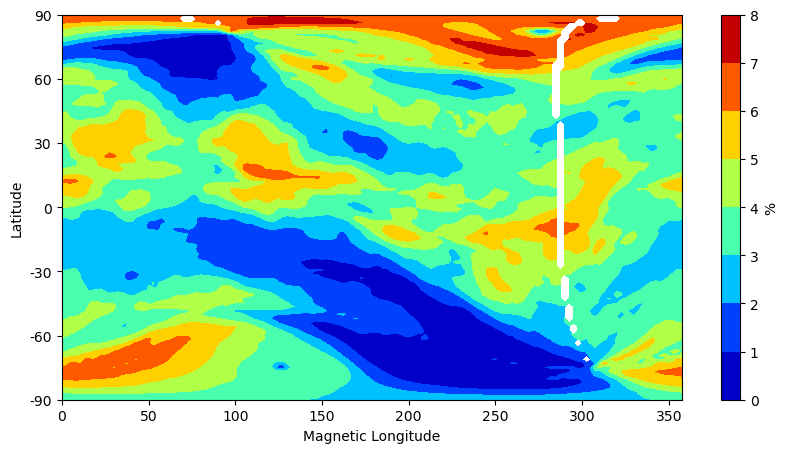

In [20]:



fig, ax = plt.subplots(figsize=(10,5))

cmap = plt.get_cmap('jet')

C = ax.contourf(#mlonsh_plot, mlat, interpolated_data_plot
                mlon, mlat, interpolated_data
                , cmap=cmap
                #,levels=np.linspace(vminw, vmaxw, 11), vmin=vminw, vmax=vmaxw
               )

ax.set_xlabel('Magnetic Longitude')
ax.set_ylabel('Latitude')
#ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])#, crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-90, 90, 7))
ax.set_yticklabels((-90, -60, -30, 0, 30, 60, 90))

cbar = fig.colorbar(C, ax=ax)#, pad=0.04, shrink=0.8)
cbar.set_label(r'%') 


plt.show()

In [42]:
# # Roll the data along the longitude dimension
# #spr_SpEsns_Occ_Fr_dsavglevsh = np.roll(spr_SpEsns_Occ_Fr_dsavglev.values, shift=144//2, axis=-1)

# lonsh = (lon + 180) % 360 - 180    #0-360 to -180 - 180
# lonsh

<xarray.Variable (lon: 144)>
array([   0. ,    2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,
         20. ,   22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,
         40. ,   42.5,   45. ,   47.5,   50. ,   52.5,   55. ,   57.5,
         60. ,   62.5,   65. ,   67.5,   70. ,   72.5,   75. ,   77.5,
         80. ,   82.5,   85. ,   87.5,   90. ,   92.5,   95. ,   97.5,
        100. ,  102.5,  105. ,  107.5,  110. ,  112.5,  115. ,  117.5,
        120. ,  122.5,  125. ,  127.5,  130. ,  132.5,  135. ,  137.5,
        140. ,  142.5,  145. ,  147.5,  150. ,  152.5,  155. ,  157.5,
        160. ,  162.5,  165. ,  167.5,  170. ,  172.5,  175. ,  177.5,
       -180. , -177.5, -175. , -172.5, -170. , -167.5, -165. , -162.5,
       -160. , -157.5, -155. , -152.5, -150. , -147.5, -145. , -142.5,
       -140. , -137.5, -135. , -132.5, -130. , -127.5, -125. , -122.5,
       -120. , -117.5, -115. , -112.5, -110. , -107.5, -105. , -102.5,
       -100. ,  -97.5,  -95. ,  -92.5,  -90. ,  -87.5,  -85. ,  -82.5,
        -80. ,  -77.5,  -75. ,  -72.5,  -70. ,  -67.5,  -65. ,  -62.5,
        -60. ,  -57.5,  -55. ,  -52.5,  -50. ,  -47.5,  -45. ,  -42.5,
        -40. ,  -37.5,  -35. ,  -32.5,  -30. ,  -27.5,  -25. ,  -22.5,
        -20. ,  -17.5,  -15. ,  -12.5,  -10. ,   -7.5,   -5. ,   -2.5])

In [47]:
# # Convert the Variable to DataArray
# data_array = xr.DataArray(spr_SpEsns_Occ_Fr_dsavglev, coords= {'lat': lat, 'lon': lonsh} )

# # Interpolate 'SpEs_Occ_Fr_b_dsavglev' to magnetic latitude and longitude
# interpolated_data = data_array.interp(lat=avALATM, lon=avALONM)

In [22]:
# #Append additional values at the end of the array to fill in gaps in data at lon 360

# # lon.values.min() #0.0
# # lon.values.max() #357.5

# lon_ex = np.append(lon, 360)
# lon_ex.shape #145


# spr_SpEsns_Occ_Fr_dsavglev_np = spr_SpEsns_Occ_Fr_dsavglev.values
# spr_SpEsns_Occ_Fr_dsavglev_np_ex = np.column_stack([spr_SpEsns_Occ_Fr_dsavglev_np, spr_SpEsns_Occ_Fr_dsavglev_np[:, 0]])
# spr_SpEsns_Occ_Fr_dsavglev_np_ex.shape #96,145

In [54]:
#Convert 0-360 to -180 to 180
mlonsh = (mlon + 180) % 360 - 180
mlonsh

<xarray.DataArray 'lon' (lon: 144)>
array([   0. ,    2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,
         20. ,   22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,
         40. ,   42.5,   45. ,   47.5,   50. ,   52.5,   55. ,   57.5,
         60. ,   62.5,   65. ,   67.5,   70. ,   72.5,   75. ,   77.5,
         80. ,   82.5,   85. ,   87.5,   90. ,   92.5,   95. ,   97.5,
        100. ,  102.5,  105. ,  107.5,  110. ,  112.5,  115. ,  117.5,
        120. ,  122.5,  125. ,  127.5,  130. ,  132.5,  135. ,  137.5,
        140. ,  142.5,  145. ,  147.5,  150. ,  152.5,  155. ,  157.5,
        160. ,  162.5,  165. ,  167.5,  170. ,  172.5,  175. ,  177.5,
       -180. , -177.5, -175. , -172.5, -170. , -167.5, -165. , -162.5,
       -160. , -157.5, -155. , -152.5, -150. , -147.5, -145. , -142.5,
       -140. , -137.5, -135. , -132.5, -130. , -127.5, -125. , -122.5,
       -120. , -117.5, -115. , -112.5, -110. , -107.5, -105. , -102.5,
       -100. ,  -97.5,  -95. ,  -92.5,  -90. ,  -87.5,  -85. ,  -82.5,
        -80. ,  -77.5,  -75. ,  -72.5,  -70. ,  -67.5,  -65. ,  -62.5,
        -60. ,  -57.5,  -55. ,  -52.5,  -50. ,  -47.5,  -45. ,  -42.5,
        -40. ,  -37.5,  -35. ,  -32.5,  -30. ,  -27.5,  -25. ,  -22.5,
        -20. ,  -17.5,  -15. ,  -12.5,  -10. ,   -7.5,   -5. ,   -2.5])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [65]:
interpolated_data_ass = interpolated_data.assign_coords(lon=mlonsh.values)
interpolated_data_ass

lonnnn = interpolated_data_ass['lon']
latttt = interpolated_data_ass['lat']

In [24]:

# # Shift the variable along the longitude dimension
# interpolated_data_sh = interpolated_data.roll(lon=len(interpolated_data['lon']) // 2, roll_coords=True)

# # Update the coordinates in the shifted variable
# interpolated_data_sh = interpolated_data_sh.assign_coords(lon=mlonsh)
# #interpolated_data_sh

In [49]:
# interpolated_data_np = interpolated_data.values

# # Roll the NumPy array along the lon dimension
# rolled_data_np = np.roll(interpolated_data_np, shift=len(interpolated_data['lon']) // 2, axis=-1)


In [57]:
# # Convert xarray DataArray to NumPy array
# interpolated_data_np = interpolated_data.values

# # Roll the NumPy array along the lon dimension
# rolled_data_np = np.roll(interpolated_data_np, shift=len(interpolated_data['lon']) // 2, axis=-1)

# # Create a new xarray DataArray with the rolled values
# rolled_data = xr.DataArray(rolled_data_np, coords=interpolated_data.coords, dims=interpolated_data.dims)

# # Update the 'lon' coordinates in the rolled_data variable
# rolled_data = rolled_data.assign_coords(lon=mlonsh)